<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/ivan-private-Lab3/Lab3/ivan-private_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Approximation**
**Ivan Zivkovic**

# **Abstract**

The goal of this lab is to implement the $L^2$ projection of a real-valued function over a one dimensional mesh. 

# **About the code**

This report is written by Ivan Zivkovic (ivanzi@kth.se)

In [224]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [225]:
# Load neccessary modules.
#from google.colab import files

import numpy as np

from matplotlib import pyplot as plt

from typing import TypeAlias, Callable
T_NumpyVector: TypeAlias = np.ndarray
T_NumpyMatrix: TypeAlias = np.ndarray

# **Introduction**

The best possible approximation of $f$ in $V_N$ (with respect to its norm $||\cdot||_V = (\cdot, \cdot)_V^{1/2})$ is the orthogonal projection $P_N : V \rightarrow V_N$. Orthogonal projection needs for the inner product to be defined, such as in the Hilbert space $L^2([a, b])$. For the Hilbert space $L^2([a, b])$ the inner product is:
$$(f, g) = \int_a^b f(x) g(x) \; dx$$

By definition, an orthogonal projection has an error that is orthogonal to the projection space. In this case:
$$(f - P_N f, v) = 0, \;\;\;\; \forall v \in V_N$$


The $L^2$ projection $P_N f$ onto $V_N \subset L^2([a, b])$ can thus be defined as:
$$(P_N f, v) = (f, v), \;\;\;\; \forall v \in V_N$$

Now since $V_N$ can be spanned by the basis $\{ \phi_i \}_{i=1}^N$ the $L^2$ projection can be restated as:
$$\sum_{j=1}^N \alpha_j (\phi_j, \phi_i) = (f, \phi_i), \;\;\;\; \forall i = 1,...,N$$

where $\alpha$ is the coordinate of $f$ in $V_N$. 

If we assume that we have chosen a basis for $V_N$, then the $L^2$ projection can be rewritten into a matrix equation $A \alpha = b$ where:
$$a_{ij} = (\phi_j, \phi_i) = \int_a^b \phi_j(x) \phi_i(x) \; dx$$
$$b_i = (f, \phi_i) = \int_a^b f(x) \phi_i(x) \; dx$$

And from the matrix equation we can compute the coordinates $\alpha \in R^N$, and finally get the $L^2$ projection:
$$P_N f(x) = \sum_{j=1}^N \alpha_j \phi_j(x)$$


# **Method**

## **L2 projection to pw linear approximation over mesh in 1D**

To construct a $L^2$ projection of a function $f$ over a 1D mesh which is defined by a set of points $x_0, ..., x_n$ we use the following algorithm:
1. Assemble the matrix $A$ and vector $b$
2. Solve for $\alpha$ in the matrix equation $A \alpha = b$
3. Return $\alpha$

The way that we will assemble the matrix $A$ and vector $b$ is with the assembly algorithm (algorithm 9.2 in the book). How it works in a high level is that we loop over all the nodes in the mesh and for each sub-interval we calculate a local $2 \times 2$ matrix $A^k$ and a $2 \times 1$ vector $b^k$ and then we map these to the global matrix $A$ and the global vector $b$, effectively adding together the contribution of each sub-interval to the whole interval. 

The variable A_k in the algorithm corresponds to $A^k = (a_{ij}^k)$ and the variable b_k corresponds to $b^k = (b_i^k)$ which are given by:
$$a_{ij}^k = \int_{I_k} \lambda_{k, j}(x) \lambda_{k, i}(x) \; dx$$
$$b_i^k = \int_{I_k} f(x) \lambda_{k, i}(x) \; dx$$

Since we are going to use Lagrange polynomials of degree 1 we can calculate the integral $a_{ij}^k = \int_{I_k} \lambda_{k, j}(x) \lambda_{k, i}(x) \; dx$ analytically. The matrix $A^k$ is a $2 \times 2$ matrix and the integrals can be calculated analytically as shown in the book. If we further assume that the nodes in the mesh are evenly spaced out with a distance of $h$ between them, we get that:
$$a_{ii}^k = \frac{h}{3}$$
$$a_{ii+1}^k = a_{ii-1}^k = \frac{h}{6}$$


In [226]:
def integrate_matrix(k, i, j, I):
    h = I[k+1] - I[k]
    
    if i == j:
        return h / 3
    
    return h / 6

To calculate the integral $b_i^k = \int_{I_k} f(x) \lambda_{k, i}(x) \; dx$, the subinterval $I_k$ is further divided into subintervals and the trapezoidal rule is used where the function is $f(x) \lambda_{k, i}(x)$.

In [227]:
def integrate_vector(f, k, i, I):

    h = I[k+1] - I[k]
    
    def linear_lagrange_basis(x):
        if i == 0:
            return (I[k+1] - x) / h
        # i == 1:
        return (x - I[k]) / h
    
    # to get a better integral approximation, 
    # the interval I_k is split into 10 subintervals
    x = np.linspace(I[k], I[k+1], 10)
    y = f(x) * linear_lagrange_basis(x)
    
    return np.trapz(y, x) # integrates using the trapezoidal rule

Now the assembly algorithm can be implemented which loops over the mesh and for each sub-interval $I_k$ calculates the contribution from $A^k$ and $b^k$ to the global matrix and vector $A$ and $b$ by using the integration functions already implemented.   

In [228]:
def assemble_system(f: Callable, mesh: T_NumpyVector):
    N = max(mesh.shape) # number of subintervals in the 1D mesh
    A = np.zeros((N, N))
    b = np.zeros(mesh.shape)
    q = 1
    q_plus_one = q+1 # all local shape functions are of degree q=1, but the A_k matrices are (q+1) * (q+1) in size
    
    for k in range(N-1):
        b_k = np.zeros((q_plus_one, ))
        A_k = np.zeros((q_plus_one, q_plus_one))
        
        for i in range(q_plus_one):
            for j in range(q_plus_one):
                A_k[i, j] = integrate_matrix(k, i, j, mesh)
                
            b_k[i] = integrate_vector(f, k, i, mesh)
    
        A[k:k+q_plus_one, k:k+q_plus_one] += A_k
        b[k:k+q_plus_one] += b_k    
            
    return A, b


Finally, the $L^2$ projection function is implemented which first assembles the matrix $A$ and vector $b$ and then solves the matrix equation for $\alpha$.

In [229]:
def l2_projection_1D(f: Callable, mesh: T_NumpyVector):
    A, b = assemble_system(f, mesh)
    return np.linalg.solve(A, b) # returns alpha vector

# **Results**


## **L2 projection to pw linear approximation over mesh in 1D**

To test the accuracy and convergence rate of my $L^2$ projection implementation, the function $f(x) = \sin x$ will be projected onto a mesh of different amount of nodes. This will then be plotted against the real $f(x)$ in a graph so the difference between the approximation and normal function can be seen. 

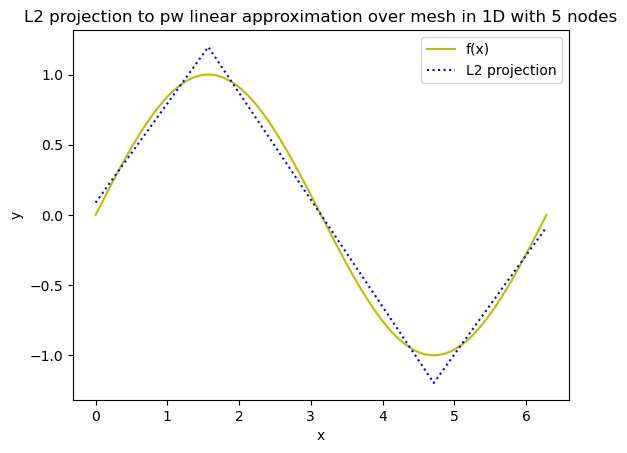

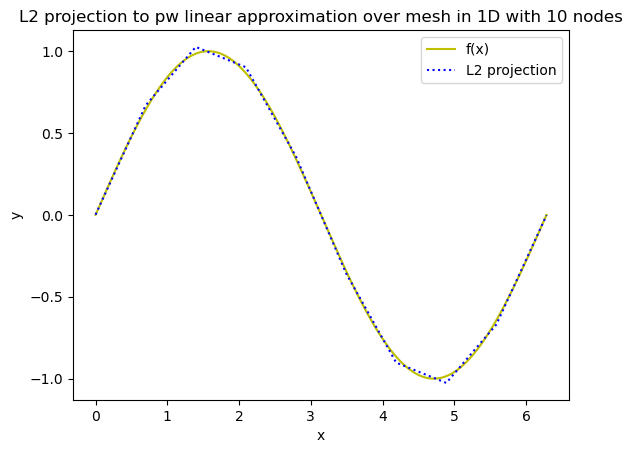

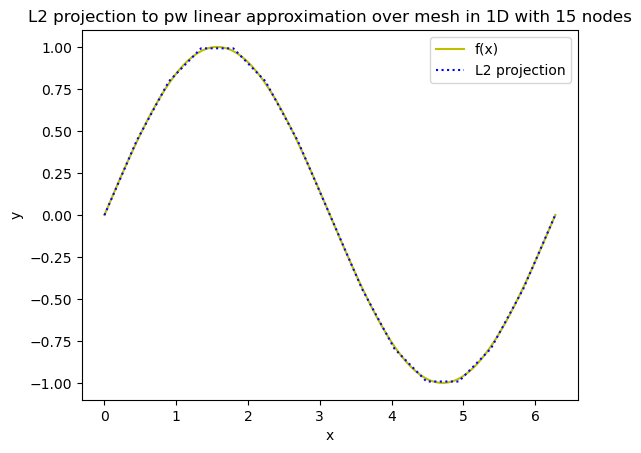

In [230]:
f_domain = np.linspace(0, 2 * np.pi, 1000) # 1000 evaluation points for f(x)=sin(x), which in the graph will look like a continuous function

f = lambda x: np.sin(x)

for nodes in [5, 10, 15]:
    mesh = np.linspace(0, 2 * np.pi, nodes)
    l2_proj = l2_projection_1D(f, mesh)
    
    plt.plot(f_domain, f(f_domain),"y", label=f"f(x)")
    plt.plot(mesh, l2_proj, ":b",label="L2 projection")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"L2 projection to pw linear approximation over mesh in 1D with {nodes} nodes")
    plt.legend()
    
    plt.show() 

# **Discussion**
As seen by the results, the more nodes that you have in your mesh, the more precision you will have in your approximation which is to be excpected. 